# Fine Tuning DistilBERT for Multiclass Text Classification

## Model - 'distilbert-base-uncased'


## Dataset Link - https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv

## First What is BERT?

BERT stands for Bidirectional Encoder Representations from Transformers. The name itself gives us several clues to what BERT is all about.

BERT architecture consists of several Transformer encoders stacked together. Each Transformer encoder encapsulates two sub-layers: a self-attention layer and a feed-forward layer.

### There are two different BERT models:

- BERT base, which is a BERT model consists of 12 layers of Transformer encoder, 12 attention heads, 768 hidden size, and 110M parameters.

- BERT large, which is a BERT model consists of 24 layers of Transformer encoder,16 attention heads, 1024 hidden size, and 340 parameters.



BERT Input and Output
BERT model expects a sequence of tokens (words) as an input. In each sequence of tokens, there are two special tokens that BERT would expect as an input:

- [CLS]: This is the first token of every sequence, which stands for classification token.
- [SEP]: This is the token that makes BERT know which token belongs to which sequence. This special token is mainly important for a next sentence prediction task or question-answering task. If we only have one sequence, then this token will be appended to the end of the sequence.


It is also important to note that the maximum size of tokens that can be fed into BERT model is 512. If the tokens in a sequence are less than 512, we can use padding to fill the unused token slots with [PAD] token. If the tokens in a sequence are longer than 512, then we need to do a truncation.

And that’s all that BERT expects as input.

BERT model then will output an embedding vector of size 768 in each of the tokens. We can use these vectors as an input for different kinds of NLP applications, whether it is text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering.


------------

**For a text classification task**, we focus our attention on the embedding vector output from the special [CLS] token. This means that we’re going to use the embedding vector of size 768 from [CLS] token as an input for our classifier, which then will output a vector of size the number of classes in our classification task.

-----------------------

![Imgur](https://imgur.com/NpeB9vb.png)

-------------------------

In [1]:
!pip  install transformers==4.22.1 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 36.3 MB/s eta 0:00:00


In [2]:
import transformers

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:
print(transformers.__version__)

4.22.1


In [4]:
!pip install -U tensorflow==2.10

In [5]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
# from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
root_path = '/content/output_transformed.csv'

In [9]:
df = pd.read_csv(root_path)
df.head()

,index,class,text
0,0,ask_howru,Are you ok?
1,1,ask_howold,How long have you been alive?
2,2,ask_isbot,Are you a bot
3,3,ask_ishuman,hey are you human
4,4,ask_whatspossible,Can you explain me in one sentence what you ar...


In [10]:
df = df.dropna()

In [11]:
df.shape

(1027, 3)

# Histogram of the count of text

In [12]:
df['count'] = df['text'].apply(lambda x: len(x.split()))

In [13]:
df.head()

,index,class,text,count
0,0,ask_howru,Are you ok?,3
1,1,ask_howold,How long have you been alive?,6
2,2,ask_isbot,Are you a bot,4
3,3,ask_ishuman,hey are you human,4
4,4,ask_whatspossible,Can you explain me in one sentence what you ar...,11


<Figure size 800x800 with 0 Axes>

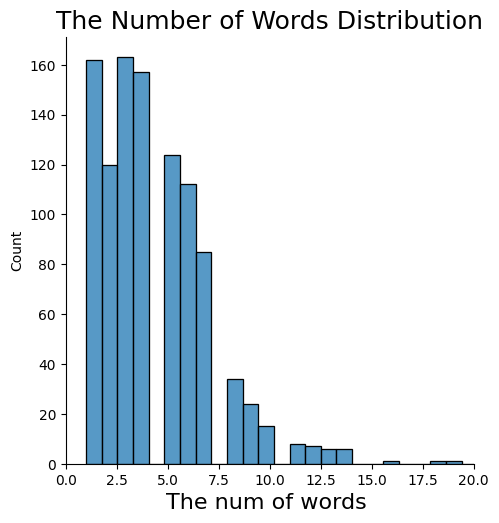

In [14]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 20)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()



# Bar plot for each of the new category

In [15]:
category_count = df['class'].value_counts()

categories = category_count.index

categories

Index(['out_of_scope', 'ask_languagesbot', 'contact_details', 'ask_howru',
       'greet', 'thank', 'founder', 'react_positive', 'location',
       'about_onpassive', 'customer_support', 'ask_whatspossible', 'goodbye',
       'ask_howold', 'ask_isbot', 'ask_ishuman', 'good_evening',
       'good_morning', 'support_feedback', 'good_night', 'ask_botcreation',
       'onpassive_profile', 'good_afternoon', 'language_support', 'ask_fyn',
       'onpassive_sucks', 'Hand_over', 'assist_me'],
      dtype='object')

In [23]:
category_count

out_of_scope         425
ask_languagesbot      63
contact_details       63
ask_howru             37
greet                 35
thank                 32
founder               28
react_positive        27
location              25
about_onpassive       25
customer_support      25
ask_whatspossible     24
goodbye               22
ask_howold            22
ask_isbot             19
ask_ishuman           18
good_evening          15
good_morning          14
support_feedback      13
good_night            13
ask_botcreation       12
onpassive_profile     12
good_afternoon        11
language_support      10
ask_fyn               10
onpassive_sucks       10
Hand_over              9
assist_me              8
Name: class, dtype: int64

In [16]:
category_count.index

Index(['out_of_scope', 'ask_languagesbot', 'contact_details', 'ask_howru',
       'greet', 'thank', 'founder', 'react_positive', 'location',
       'about_onpassive', 'customer_support', 'ask_whatspossible', 'goodbye',
       'ask_howold', 'ask_isbot', 'ask_ishuman', 'good_evening',
       'good_morning', 'support_feedback', 'good_night', 'ask_botcreation',
       'onpassive_profile', 'good_afternoon', 'language_support', 'ask_fyn',
       'onpassive_sucks', 'Hand_over', 'assist_me'],
      dtype='object')

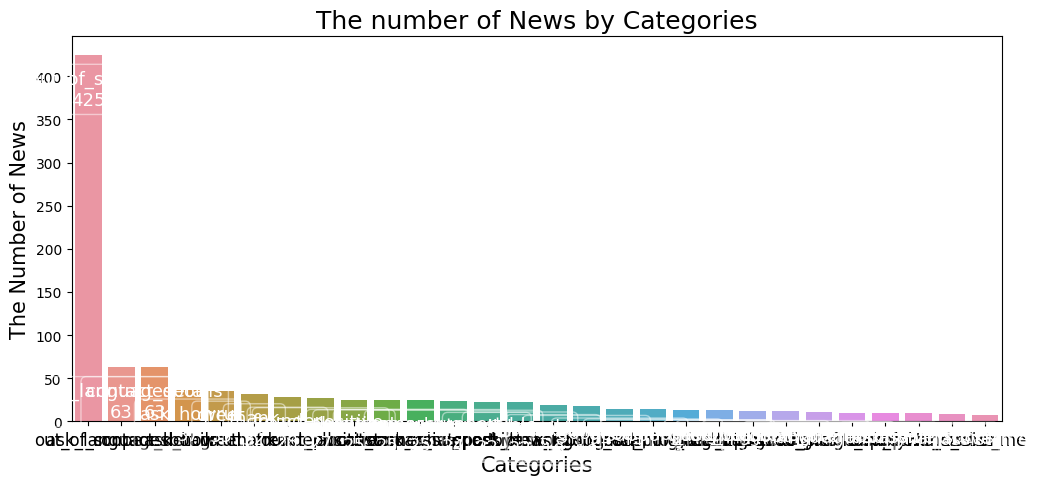

In [17]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [18]:
df['class'].unique()

array(['ask_howru', 'ask_howold', 'ask_isbot', 'ask_ishuman',
       'ask_whatspossible', 'ask_languagesbot', 'ask_fyn',
       'ask_botcreation', 'Hand_over', 'customer_support',
       'support_feedback', 'contact_details', 'react_positive', 'goodbye',
       'thank', 'language_support', 'assist_me', 'greet', 'good_morning',
       'good_afternoon', 'good_evening', 'good_night', 'about_onpassive',
       'founder', 'location', 'onpassive_profile', 'onpassive_sucks',
       'out_of_scope'], dtype=object)

In [19]:
df['encoded_text'] = df['class'].astype('category').cat.codes

df.head(10)

,index,class,text,count,encoded_text
0,0,ask_howru,Are you ok?,3,5
1,1,ask_howold,How long have you been alive?,6,4
2,2,ask_isbot,Are you a bot,4,6
3,3,ask_ishuman,hey are you human,4,7
4,4,ask_whatspossible,Can you explain me in one sentence what you ar...,11,9
5,5,ask_languagesbot,Are you familiar with more than one language?,8,8
6,6,ask_fyn,im fine,2,3
7,7,ask_botcreation,wer r u,3,2
8,8,Hand_over,Can I talk to a real agent?,7,0
9,9,customer_support,service,1,12


In [35]:
df["encoded_text"].unique(), df["class"].unique()

(array([ 5,  4,  6,  7,  9,  8,  3,  2,  0, 12, 26, 11, 25, 18, 27, 20, 10,
        19, 16, 14, 15, 17,  1, 13, 21, 22, 23, 24], dtype=int8),
 array(['ask_howru', 'ask_howold', 'ask_isbot', 'ask_ishuman',
        'ask_whatspossible', 'ask_languagesbot', 'ask_fyn',
        'ask_botcreation', 'Hand_over', 'customer_support',
        'support_feedback', 'contact_details', 'react_positive', 'goodbye',
        'thank', 'language_support', 'assist_me', 'greet', 'good_morning',
        'good_afternoon', 'good_evening', 'good_night', 'about_onpassive',
        'founder', 'location', 'onpassive_profile', 'onpassive_sucks',
        'out_of_scope'], dtype=object))

In [20]:
data_texts = df['text'].to_list()

data_labels = df['encoded_text'].to_list()

# Train Test SPlit

In [21]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )



# Model Definition

In [22]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

# Fine-tuning with the TFTrainer class

In [24]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [25]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments


training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=1e-5,
    logging_dir='./logs',
    eval_steps=100
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 5 )


trainer = TFTrainer(
    model=trainer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_39', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [26]:
trainer.train()

In [46]:
trainer.evaluate()

{'eval_loss': nan}

# Saving & Loading the model

In [29]:
save_directory = "/saved_models"

model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('/saved_models/tokenizer_config.json',
 '/saved_models/special_tokens_map.json',
 '/saved_models/vocab.txt',
 '/saved_models/added_tokens.json')

# Loading Pre-Trained Model

In [30]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /saved_models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /saved_models and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
test_text = "Hi"

test_text

'Hi'

In [38]:
df["encoded_text"].unique(), df["class"].unique()

(array([ 5,  4,  6,  7,  9,  8,  3,  2,  0, 12, 26, 11, 25, 18, 27, 20, 10,
        19, 16, 14, 15, 17,  1, 13, 21, 22, 23, 24], dtype=int8),
 array(['ask_howru', 'ask_howold', 'ask_isbot', 'ask_ishuman',
        'ask_whatspossible', 'ask_languagesbot', 'ask_fyn',
        'ask_botcreation', 'Hand_over', 'customer_support',
        'support_feedback', 'contact_details', 'react_positive', 'goodbye',
        'thank', 'language_support', 'assist_me', 'greet', 'good_morning',
        'good_afternoon', 'good_evening', 'good_night', 'about_onpassive',
        'founder', 'location', 'onpassive_profile', 'onpassive_sucks',
        'out_of_scope'], dtype=object))

In [42]:
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

prediction_value

1

# Inferencing with Pytorch

In [43]:
import torch

from transformers import DistilBertForSequenceClassification

tokenizer_fine_tuned_pt = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned_pt = DistilBertForSequenceClassification.from_pretrained(save_directory, from_tf = True )


All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


In [44]:
predict_input_pt = tokenizer_fine_tuned_pt(test_text, truncation = True, padding = True, return_tensors = 'pt' )

ouput_pt = model_fine_tuned_pt(predict_input_pt)

prediction_value_pt = torch.argmax(ouput_pt[0], dim = 1 ).item()

prediction_value_pt

AttributeError: ignored